In [229]:
import os
os.getcwd()

'd:\\Crider_Forecasting\\notebooks'

In [230]:
import sys
sys.path.append('d:\\Crider_Forecasting\\notebooks')


In [231]:
print(sys.path)

['d:\\Crider_Forecasting\\notebooks', 'c:\\Users\\EMPULSE\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\EMPULSE\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\EMPULSE\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\EMPULSE\\AppData\\Local\\Programs\\Python\\Python39', '', 'C:\\Users\\EMPULSE\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\EMPULSE\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\EMPULSE\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\EMPULSE\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\EMPULSE\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'd:\\Crider_Forecasting\\notebooks', 'd:\\Crider_Forecasting\\notebooks', 'd:\\Crider_Forecasting\\notebooks', 'd:\\Crider_Forecasting\\notebooks', 'd:\\Crider_Forecasting\\notebooks', 'd:\\Crider_Forecasting\\notebooks', 'd:\\Crider_Forecasting\\notebooks', 'd

In [232]:
import pandas as pd
import numpy as np
import logging
from importlib import import_module
import utils
import yaml
from utils import read_config
from utils import read_process
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler

In [233]:
print(pd.__version__)

2.1.1


In [234]:
def read_data(file_type='excel', **kwargs):
    config = read_process()
    file_path = config.get('file_path', None)
    supported_file_types = config.get('supported_file_types', [])

    if file_path is None:
        raise ValueError("File path is not specified in the configuration.")

    if file_type not in supported_file_types:
        raise ValueError(f"Unsupported file type: {file_type}. Supported types: {', '.join(supported_file_types)}")

    try:
        if file_type == 'csv':
            data = pd.read_csv(file_path, **kwargs)
        elif file_type == 'excel':
            data = pd.read_excel(file_path, **kwargs)
        else:
            raise ValueError(f"Unsupported file type: {file_type}")
        
        logging.info(f'Succefully read data')
        print(data.head())
        return data

    except Exception as e:
        logging.error(f"Error reading data from {file_type} file: {e}")
        return None

data = read_data(file_type='excel')

[2024-02-05 11:44:13,430: INFO: 3867729312: Succefully read data]
          Periods     CATEGORY             $         Units  Avg Unit Price  \
0  1 w/e 10/10/20  CANNED MEAT  2.185034e+07  7.743529e+06           2.822   
1  1 w/e 10/10/20        CHILI  1.271787e+07  6.085839e+06           2.090   
2  1 w/e 10/10/20         TUNA  3.419911e+07  1.980385e+07           1.727   
3  1 w/e 10/10/20         TUNA  2.566521e+07  1.402874e+07           1.829   
4  1 w/e 10/10/20         STEW  2.919072e+06  1.101263e+06           2.651   

   Base Unit Price  Any Promo $  Any Promo Units  
0            2.876  1769644.466       697890.443  
1            2.200  2008533.993      1094479.367  
2            1.859  6450261.441      5357730.966  
3            1.980  4147577.768      3358454.914  
4            2.699   311030.204       130129.797  


In [235]:
#if using correctyogurt.csv use the below code
#data.drop(columns='sum(DOLLARS)', axis= 1, inplace=True)

#while using demo.xlsx use the below code.
data.drop(columns=['Any Promo $'], axis=1, inplace=True)

In [236]:
def check_leading_spaces(data):
        try:
            columns_with_spaces = [col for col in data.columns if col.startswith(" ")]
            logging.info('check_leading_spaces completed')
            return columns_with_spaces
        except Exception as e:
              logging.error(f'error checking for leading spaces: {e}')
              return None

check_leading_spaces(data)

[2024-02-05 11:44:13,485: INFO: 3886999444: check_leading_spaces completed]


[]

In [237]:
def detect_date_column(data):
        
        config=read_process()
        date_formats = config.get('date_formats', [])

        if not date_formats:
            logging.warning("No date formats specified in the config file. Using default formats.")
            # If date_formats are changed or not present, use the default paramters declared here.
            #date_formats = ['%Y-%m-%d', '%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f', '%Y%m%d', '%m/%d/%Y', '%m/%d/%y', '%d/%m/%Y', '%d/%m/%y', 'w/e %m/%d/%y']
        for column in data.columns:
            for date_format in date_formats:
                try:
                    pd.to_datetime(data[column], format=date_format, errors='coerce')
                    logging.info(f"Detected '{column}' as a potential date column using format '{date_format}'.")
                    
                    return column
                except ValueError:
                    pass  # Ignore errors and try the next format
        logging.info("No potential date column detected.")
        return None

detect_date_column(data)

[2024-02-05 11:44:13,517: INFO: 3221717508: Detected 'Periods' as a potential date column using format '%Y-%m-%d'.]


'Periods'

In [238]:
def check_date_columns_keyword(data):
    config = read_process()
    date_column_keywords = config.get('date_column_keywords', [])
    
    detected_date_columns=[]
    
    date_columns = [col for col in data.columns if any(keyword.lower() in col.lower() for keyword in date_column_keywords)]

    if date_columns:
        print("Potential date columns found:")
        for col in date_columns:
            print(f"- {col}")
            detected_date_columns.append(col)
    else:
        print("No potential date columns found.")
    return date_columns

date_columns = check_date_columns_keyword(data)

Potential date columns found:
- Periods


In [239]:
def sort_dataset_by_date(data, date_columns):

    sorted_data = data.sort_values(by=date_columns)
    return sorted_data

In [240]:
def remove_prefix(data, date_columns):
    for col in date_columns:
        data[col] = data[col].str.replace(r'^1 w/e ', '', regex=True)
    return data

remove_prefix(data,date_columns)

,Periods,CATEGORY,$,Units,Avg Unit Price,Base Unit Price,Any Promo Units
0,10/10/20,CANNED MEAT,2.185034e+07,7.743529e+06,2.822,2.876,697890.443
1,10/10/20,CHILI,1.271787e+07,6.085839e+06,2.090,2.200,1094479.367
2,10/10/20,TUNA,3.419911e+07,1.980385e+07,1.727,1.859,5357730.966
3,10/10/20,TUNA,2.566521e+07,1.402874e+07,1.829,1.980,3358454.914
4,10/10/20,STEW,2.919072e+06,1.101263e+06,2.651,2.699,130129.797
...,...,...,...,...,...,...,...
21661,10/07/23,CHILI,1.583478e+05,6.402600e+04,2.473,2.590,12438.260
21662,10/07/23,TUNA,7.192997e+05,3.658650e+05,1.966,2.028,147150.371
21663,10/07/23,TUNA,4.027962e+05,1.657860e+05,2.430,2.510,89445.302
21664,10/07/23,STEW,1.670167e+04,5.106000e+03,3.271,3.348,626.320


In [241]:
def extract_date_part(data, date_columns):
    for col in date_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')
        data[col] = data[col].dt.strftime('%m-%d-%y')
    return data

data = extract_date_part(data, date_columns)

C:\Users\EMPULSE\AppData\Local\Temp\ipykernel_3716\2260327217.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [242]:
def set_date_column_as_index(data, date_column):
        if date_column in data.columns:
            data.set_index(date_column, inplace=True)
            print(f"Index set to the '{date_column}' column.")
        else:
            print(f"Error: '{date_column}' not found in the columns.")
        return data

date_column_to_use_as_index = date_columns[0]

data = set_date_column_as_index(data, date_column_to_use_as_index)

Index set to the 'Periods' column.


In [243]:
def detect_column_types(data):
    numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

    # Log information about detected column types
    logging.info(f"Numerical columns: {numerical_columns}")
    logging.info(f"Categorical columns: {categorical_columns}")

    return numerical_columns, categorical_columns

numerical_cols , categorical_cols = detect_column_types(data)

[2024-02-05 11:44:18,633: INFO: 4117177363: Numerical columns: ['$', 'Units', 'Avg Unit Price', 'Base Unit Price', 'Any Promo Units']]
[2024-02-05 11:44:18,637: INFO: 4117177363: Categorical columns: ['CATEGORY']]


In [ ]:
def convert_numerical_columns_to_float(data, numerical_columns):

        try:
            for column in numerical_columns:
                data[column] = data[column].astype(float)
                logging.info(f"Converted '{column}' to float data type.")
            
            return data
        except Exception as e:
            logging.error(f"Error occurred while converting numerical columns to float: {str(e)}")
            return None

In [244]:
def one_hot_encode_categorical_columns(data, categorical_columns):
    
    data[categorical_columns] = data[categorical_columns].astype(str)
    
    encoded_data = pd.get_dummies(data, columns=categorical_columns, drop_first=False)
    
    data.drop(columns=categorical_columns, inplace=True)
    
    data[encoded_data.columns] = encoded_data

    logging.info(f"One-Hot Encoding applied to categorical columns: {categorical_columns}")
    logging.info(f"One-Hot encoded columns appended to the original dataset. Updated dataset shape: {data.shape}")

    return data

data = one_hot_encode_categorical_columns(data, categorical_cols)

[2024-02-05 11:44:18,988: INFO: 2748747421: One-Hot Encoding applied to categorical columns: ['CATEGORY']]
[2024-02-05 11:44:18,988: INFO: 2748747421: One-Hot encoded columns appended to the original dataset. Updated dataset shape: (21666, 9)]


In [245]:
def find_target_column(data):
        try:
            config = read_process()
            target_column_keywords = config.get('target_column_keywords', ['Target'])

            target_columns = []
            for keyword in target_column_keywords:
                for column in data.columns:
                    if keyword.lower() in column.lower():
                        logging.info(f"Found target column: {column}")
                        target_columns.append(column)

            if target_columns:
                return target_columns

            logging.warning("Target column not found in the dataset columns.")
            return None

        except Exception as e:
            logging.error(f"Error occurred while finding target column: {str(e)}")
            return None
        
target_columns = find_target_column(data)

[2024-02-05 11:44:25,280: INFO: 4267331785: Found target column: $]


In [ ]:
def remove_special_characters(data, target_columns):

        try:
            config = read_process()
            target_column_keywords = config.get('target_column_keywords', ['Target'])

            for target_column in target_columns:
                data[target_column] = data[target_column].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x)))
                logging.info(f"Special characters removed from '{target_column}' column.")
                return data
            
        except Exception as e:
            logging.error(f"Error occurred while removing special characters: {str(e)}")
            return None

In [ ]:
def convert_numerical_columns_to_float(data, numerical_columns):

        try:
            for column in numerical_columns:
                data[column] = data[column].astype(float)
                logging.info(f"Converted '{column}' to float data type.")
            
            return data
        except Exception as e:
            logging.error(f"Error occurred while converting numerical columns to float: {str(e)}")
            return None

In [246]:
def handle_null_values(data):
    try:
        config = read_process()
        missing_values = config.get('missing_values', [])

        for missing_value in missing_values:
            data.replace(missing_value, pd.NA, inplace=True)

        data.ffill(inplace=True)
        data.bfill(inplace=True)

        null_count = data.isnull().sum().sum()
        logging.info(f"Missing values handled. Null count after treatment: {null_count}")

    except FileNotFoundError as e:
        logging.error(f'Config file not found: {str(e)}')
    except Exception as e:
        logging.error(f'An error occurred: {str(e)}')

handle_null_values(data)

[2024-02-05 11:44:28,552: INFO: 4227659725: Missing values handled. Null count after treatment: 0]


In [247]:
def detect_outliers_in_target(data, target_columns, threshold=3):
        
        outliers = pd.DataFrame(index=data.index, columns=target_columns)

        for target_column in target_columns:
            z_scores = np.abs((data[target_column] - data[target_column].mean()) / data[target_column].std())
            outliers[target_column] = z_scores > threshold
            
            # Create a new column 'outlier' with True if any target column is an outlier
            outliers['outlier'] = outliers.any(axis=1)

            logging.info(f'Outliers Detected in target column {target_column}')

            # Filter the original DataFrame to include only rows with outliers
            result_data = data[outliers['outlier']]
            
        return result_data

detect_outliers_in_target(data, target_columns, threshold=3)

[2024-02-05 11:44:34,864: INFO: 3149303080: Outliers Detected in target column $]


,$,Units,Avg Unit Price,Base Unit Price,Any Promo Units,CATEGORY_CANNED MEAT,CATEGORY_CHILI,CATEGORY_STEW,CATEGORY_TUNA
Periods,,,,,,,,,
10-10-20,2.185034e+07,7.743529e+06,2.822,2.876,697890.443,True,False,False,False
10-10-20,3.419911e+07,1.980385e+07,1.727,1.859,5357730.966,False,False,False,True
10-10-20,2.566521e+07,1.402874e+07,1.829,1.980,3358454.914,False,False,False,True
10-17-20,2.117691e+07,7.629345e+06,2.776,2.864,875571.401,True,False,False,False
10-17-20,3.257324e+07,1.868280e+07,1.743,1.857,3983485.090,False,False,False,True
...,...,...,...,...,...,...,...,...,...
09-16-23,1.976790e+07,9.638832e+06,2.051,2.247,3693627.102,False,False,False,True
09-23-23,1.929587e+07,9.679725e+06,1.993,2.249,4199822.192,False,False,False,True
09-30-23,1.906322e+07,9.562792e+06,1.993,2.261,4146478.656,False,False,False,True


In [ ]:
# def treat_outliers_with_median(data, column, threshold=1.5):

#     median = data[column].median()
#     q1 = data[column].quantile(0.25)
#     q3 = data[column].quantile(0.75)
#     iqr = q3 - q1

#     lower_bound = q1 - threshold * iqr
#     upper_bound = q3 + threshold * iqr

#     data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])

#     return data

# treat_outliers_with_median(data, target_columns)

In [248]:
logging.basicConfig(level=logging.INFO)

def winsorize_data(data, target_columns, lower_percentile=0.05, upper_percentile=0.95):

    winsorized_data = data.copy()

    for target_column in target_columns:
        lower_limit = winsorized_data[target_column].quantile(lower_percentile)
        upper_limit = winsorized_data[target_column].quantile(upper_percentile)
        winsorized_data[target_column] = np.clip(winsorized_data[target_column], lower_limit, upper_limit)

        logging.info(f'Outlier Treatment completed on target column {target_column}')

    return winsorized_data

data = winsorize_data(data, target_columns)

[2024-02-05 11:44:44,511: INFO: 2025814116: Outlier Treatment completed on target column $]


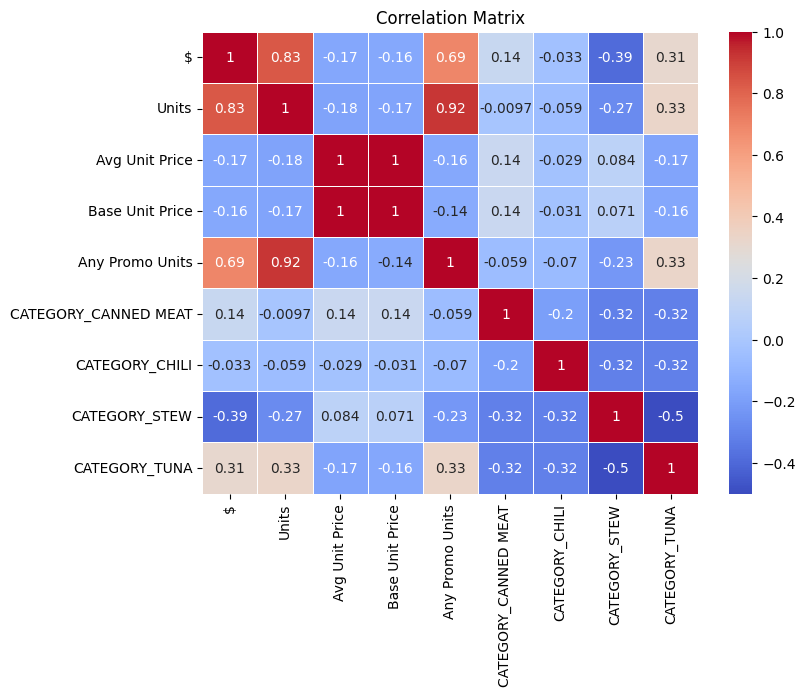

Selected features based on correlation with the targets (threshold=0.5):
          Any Promo Units         Units             $
Periods                                              
10-10-20       697890.443  7.743529e+06  1.022633e+07
10-10-20      1094479.367  6.085839e+06  1.022633e+07
10-10-20      5357730.966  1.980385e+07  1.022633e+07
10-10-20      3358454.914  1.402874e+07  1.022633e+07
10-10-20       130129.797  1.101263e+06  2.919072e+06
...                   ...           ...           ...
10-07-23        12438.260  6.402600e+04  1.583478e+05
10-07-23       147150.371  3.658650e+05  7.192997e+05
10-07-23        89445.302  1.657860e+05  4.027962e+05
10-07-23          626.320  5.106000e+03  1.777806e+04
10-07-23          626.320  5.106000e+03  1.777806e+04

[21666 rows x 3 columns]


In [249]:
def correlation_analysis(data, target_columns, threshold=0.5):
    correlation_matrix = data.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()

    selected_features = []

    for target_column in target_columns:
        target_correlation = correlation_matrix[target_column].abs().sort_values(ascending=False)
        selected_features.extend(target_correlation[target_correlation > threshold].index.tolist())

    selected_features = list(set(selected_features))

    print(f"Selected features based on correlation with the targets (threshold={threshold}):")
    selected_data = data[selected_features]

    print(selected_data)
    
    return selected_data

selected_data = correlation_analysis(data, target_columns, threshold=0.5)

In [252]:
def normalize_dataset(selected_data):
    scaler = MinMaxScaler()
    normalised_data = scaler.fit_transform(selected_data)

    normalised_data = pd.DataFrame(normalised_data, columns= selected_data.columns, index=selected_data.index)

    return normalised_data

normalised_df = normalize_dataset(selected_data)

In [254]:
def convert_to_numpy(normalised_df):
    np_data = normalised_df.to_numpy()

    return np_data

np_data = convert_to_numpy(normalised_df)

In [256]:
print(np_data)

[[5.64605822e-02 3.33903204e-01 1.00000000e+00]
 [8.85453338e-02 2.62421323e-01 1.00000000e+00]
 [4.33449996e-01 8.53960489e-01 1.00000000e+00]
 ...
 [7.23628454e-03 7.14059572e-03 3.77152542e-02]
 [5.06704056e-05 2.11855252e-04 0.00000000e+00]
 [5.06704056e-05 2.11855252e-04 0.00000000e+00]]


In [1]:
def __init__(self, processed_data, window=42, forecast=7, shift=7, single=False):
        self._data = processed_data.copy()
        self.window = window
        self.forecast = forecast
        self.shift = shift
        if single is False:
            self.build_training_data()
            logging.info("Done Initializing")

In [2]:
def rolling_transformation(self):
        num_windows = int((len(self._data) - self.window) / self.shift) + 1
        dataset = []
        for i in range(num_windows):
            min = 0 + self.shift * i
            max = self.window + self.shift * i
            array = self._data[min:max]
            np_array = np.array(array)
            dataset.append(np_array)
        self.dataset = np.array(dataset)
        one = self.dataset[:,:,1:].copy()
        input_1 = []
        for i in range(one.shape[0]):
            input_1.append( one[i] )
        self.input_1 = np.array(input_1)
        two = self.dataset[:,:-1*self.forecast,0:1].copy()
        input_2 = []
        for i in range(two.shape[0]):
            input_2.append( two[i] )
        self.input_2 = np.array(input_2)
        out = self.dataset[:,-1*self.forecast:,0:1].copy()
        output = []
        for i in range(out.shape[0]):
            output.append(  out[i]  )
        self.output = np.array(output)

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("D:\Crider_Forecasting\crider_forecasting\\notebooks\garments_worker_productivity.csv")

In [3]:
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [4]:
df.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

In [5]:
df['over_time'].unique()

array([ 7080,   960,  3660,  1920,  6720,  6900,  6000,  6480,  2160,
        7200,  1440,  6600,  5640,  1560,  6300,  6540, 13800,  6975,
        7020,  6780,  4260,  6660,  4320,  6960,  2400,  3840,  4800,
        4440,  1800,  2700, 10620, 10350,  9900,  5310, 10170,  4470,
       10530, 10440,  5490,  5670,  9720, 12600, 10050, 15120, 14640,
         900, 25920, 10260,  2760,  4710,  9540,  7680,  3600,  6420,
        7980,  3240,  8220,  6930,  8460,  7350,  5400,  1620,  1980,
        2970,  7320,  5100,  3390,  1260,  3420,  8970,  4950, 10080,
        9810,  6570,  5040,  4380,  3630,  8280,  6120,  5580,  3720,
        5760,  7470, 10500,  6360,  4140,  8400, 12180,  9000, 15000,
       10770, 12000,  9360,  3060,  2520,   720,  3780, 10320,   360,
        6840,  1080,  1200,  4080,   240,  5880,  6240,  4200,  3960,
         600,  2280,  5940,  1320,  5460,  2040,  4020,  3000,  3360,
        5820,  6060,  2640,  7500,  2880,   120,  3300,     0,  3480,
        7380,  4560,

In [6]:
df['idle_time'].unique()

array([  0. ,  90. , 150. , 270. , 300. ,   2. ,   5. ,   8. ,   4.5,
         3.5,   4. ,   6.5])